# Atmospheric Rivers: Filtering by Criteria

This notebook will import functions from the `ar_detection.py` module to expose the processing flow and to show a few examples.
Production runs could also be orchestrated from this notebook to leverage the use of an interactive Dask client if/when needed. Before executing this notebook be sure you've set your `AR_DATA_DIR` environment variable, and have executed both the `download.py` and `compute_ivt.py` scripts.

In [1]:
import random

import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import ar_params, ard_fp, shp_fp

# functions to create the binary "blobs" of IVT exceedance
from ar_detection import compute_intensity_mask, label_contiguous_mask_regions
# functions to measure the requisite blob properties
from ar_detection import generate_region_properties, get_data_for_ar_criteria, get_azimuth_of_furthest_points, get_directional_coherence, get_length_width_ratio, get_major_axis_haversine_distance, get_poleward_strength
# functions test whether or not criteria are met
from ar_detection import apply_criteria, filter_ars
# functions to generate vectorized output
from ar_detection import create_geodataframe_with_all_ars, create_shapefile

In [2]:
# inspect criteria, note that `window` and `ivt_percentile` are used in the IVT computation, not in the AR filtering done here
ar_params

{'window': 75,
 'ivt_percentile': 85,
 'ivt_floor': 100,
 'direction_deviation_threshold': 45,
 'mean_meridional': 50,
 'orientation_deviation_threshold': 45,
 'min_axis_length': 2000}

In [3]:
ivt_ds = xr.open_dataset(ard_fp)
ivt_ds.rio.write_crs("epsg:4326", inplace=True)
ivt_ds

<xarray.Dataset>
Dimensions:       (time: 43832, latitude: 225, longitude: 237)
Coordinates:
  * time          (time) datetime64[ns] 1992-01-01 ... 2021-12-31T18:00:00
  * longitude     (longitude) float32 -179.0 -178.8 -178.5 ... -120.2 -120.0
  * latitude      (latitude) float32 66.0 65.75 65.5 65.25 ... 10.5 10.25 10.0
    spatial_ref   int64 0
Data variables:
    p72.162       (time, latitude, longitude) float32 ...
    ivt_mag       (time, latitude, longitude) float32 ...
    ivt_dir       (time, latitude, longitude) float32 ...
    ivt_quantile  (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-08 18:05:11 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
%%time
ivt_ds["thresholded"] = compute_intensity_mask(ivt_ds["ivt_mag"], ivt_ds["ivt_quantile"], ar_params["ivt_floor"])

CPU times: user 16.9 s, sys: 22.7 s, total: 39.6 s
Wall time: 40.3 s


In [5]:
%%time
labeled_regions = label_contiguous_mask_regions(ivt_ds["thresholded"])

CPU times: user 1min 6s, sys: 3.14 s, total: 1min 9s
Wall time: 1min 9s


In [6]:
%%time
ar_di = generate_region_properties(labeled_regions, ivt_ds)

CPU times: user 7min 10s, sys: 1min, total: 8min 11s
Wall time: 8min 11s


In [7]:
%%time
ar_di = get_data_for_ar_criteria(ar_di, ivt_ds)

Getting axis length (km) for each AR target:: 100%|██████████| 43832/43832 [09:09<00:00, 79.83it/s] 
Getting overall orientation (azimuth) for each AR target:: 100%|██████████| 43832/43832 [07:17<00:00, 100.22it/s]
Getting mean poleward strength for each AR target:: 100%|██████████| 43832/43832 [00:57<00:00, 762.14it/s] 
Getting directional coherence for each AR target:: 100%|██████████| 43832/43832 [02:31<00:00, 288.95it/s]

CPU times: user 24min 31s, sys: 1min 2s, total: 25min 33s
Wall time: 25min 25s


In [8]:
%%time
ar_di = apply_criteria(ar_di)

100%|██████████| 43832/43832 [00:02<00:00, 16439.86it/s]

CPU times: user 2.34 s, sys: 346 ms, total: 2.68 s
Wall time: 2.67 s


In [14]:
# criteria exploration
# how many labeled regions meet the different numbers of criteria? 
# note that some criteria (overall orientation consistency) may oscillate between pass and fail depending on size of spatial domain


blob_count = 0

for b in ar_di:
    no_blobs = len(ar_di[b]["ar_targets"])
    blob_count = blob_count + no_blobs

print("TOTAL CANDIDATE ARs: " + str(blob_count))

crit_no = [1,2,3,4,5]
blob_crit = []

for c in crit_no:
    ars = filter_ars(ar_di, n_criteria_required=c)

    crit_count = 0

    for a in ars:
        ar_count = len(ars[a])
        crit_count = crit_count + ar_count
    
    blob_crit.append(crit_count)

for c, b in zip(crit_no, blob_crit):
    print("If requiring " + str(c) + " AR criteria, we find " + str(b) + " ARs...")

TOTAL CANDIDATE ARs: 549107


  0%|          | 0/43832 [00:00<?, ?it/s]

100%|██████████| 43832/43832 [00:00<00:00, 168900.89it/s]

If requiring 1 AR criteria, we find 549107 ARs...
If requiring 2 AR criteria, we find 527427 ARs...
If requiring 3 AR criteria, we find 354711 ARs...
If requiring 4 AR criteria, we find 129353 ARs...
If requiring 5 AR criteria, we find 23733 ARs...


In [10]:
%%time
# default criteria is the maximum (5)
output_ars = filter_ars(ar_di, n_criteria_required=5)

100%|██████████| 43832/43832 [00:00<00:00, 169051.23it/s]

CPU times: user 262 ms, sys: 5.72 ms, total: 268 ms
Wall time: 263 ms


Text(0.5, 1.0, 'AR candidate blobs')

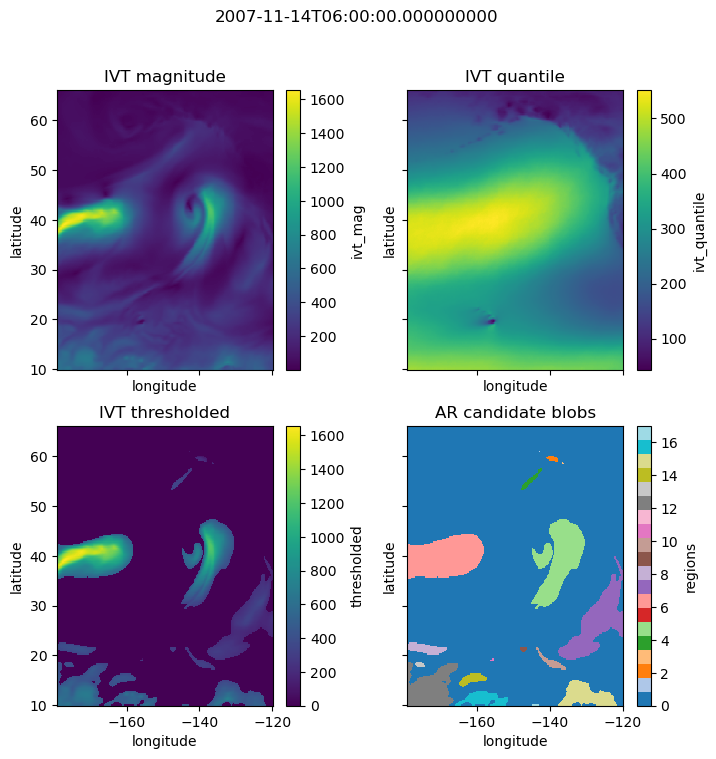

In [11]:
#plot a random timestep from the filtered ARs

random_date = random.choice(list(output_ars.keys()))
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8,8))
plt.subplots_adjust(wspace=0.3)
plt.suptitle(random_date)

ivt_ds["ivt_mag"].sel(time=random_date).plot(ax=axes[0,0])
ivt_ds["ivt_quantile"].sel(time=random_date).plot(ax=axes[0,1])
ivt_ds["thresholded"].sel(time=random_date).plot(ax=axes[1,0])
labeled_regions.sel(time=random_date).plot(ax=axes[1,1], cmap="tab20")

axes[0,0].set_title("IVT magnitude")
axes[0,1].set_title("IVT quantile")

axes[1,0].set_title("IVT thresholded")
axes[1,1].set_title("AR candidate blobs")

In [12]:
%%time
#create a master geodataframe of filtered ARs
gdf = create_geodataframe_with_all_ars(output_ars, ar_di, labeled_regions, ivt_ds)

  6%|▌         | 1203/21234 [00:25<09:00, 37.08it/s]

100%|██████████| 21234/21234 [08:00<00:00, 44.16it/s]


CPU times: user 7min 22s, sys: 25.8 s, total: 7min 47s
Wall time: 8min 17s


In [13]:
#export as shapefile
#note the warning .... column names may need to be mapped to shorter names in export function
create_shapefile(gdf, shp_fp)

/home/UA/jdpaul3/ar_avalanche/ar_detection.py:509: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  all_ars.to_file(fp)


In [15]:
ivt_ds.close()

,time,blob_label,geometry,length/width ratio,major axis length (km),overall orientation,mean poleward strength,directional_coherence,mean_of_ivt_dir,Coherence in IVT Direction,Mean Meridional IVT,Consistency Between Mean IVT Direction and Overall Orientation,Length,Length/Width Ratio,Criteria Passed
22783,2020-12-01T00:00:00.000000000,2.0,"POLYGON ((-149.62500 61.62500, -149.62500 61.3...",2.8,4258,25,240,79,359,True,True,True,True,True,5


<Axes: >

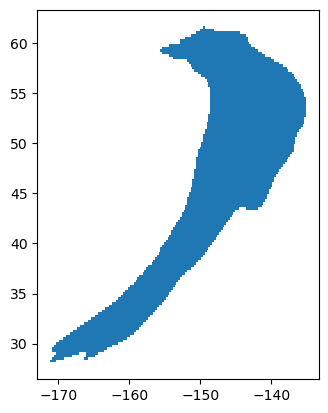

In [15]:
#checking out the Haines 2020 AR event....the region property values seems reasonable when compared to the image! 
display(gdf.loc[gdf['time']=='2020-12-01T00:00:00.000000000'])
gdf.loc[gdf['time']=='2020-12-01T00:00:00.000000000', 'geometry'].plot()

In [16]:
#briefly convert the geodataframe crs 
#epsg 3338 should be replaced with a pacific ocean planar coordinate system! This is just to get some numbers for sorting!
gdf_3338 = gdf.to_crs('epsg:3338')
gdf['espg3338_area_km2'] = gdf_3338.area/1000000

In [18]:
#get range of polygon areas
print(gdf['espg3338_area_km2'].min())
print(gdf['espg3338_area_km2'].median())
print(gdf['espg3338_area_km2'].max())


148855.5102447257
1775711.517074264
10125201.22117963


,time,blob_label,geometry,length/width ratio,major axis length (km),overall orientation,mean poleward strength,directional_coherence,mean_of_ivt_dir,Coherence in IVT Direction,Mean Meridional IVT,Consistency Between Mean IVT Direction and Overall Orientation,Length,Length/Width Ratio,Criteria Passed,espg3338_area_km2
85,1992-01-29T06:00:00.000000000,3.0,"POLYGON ((-125.12500 50.12500, -125.12500 49.3...",4.3,5615,43,210,78,359,True,True,True,True,True,5,5.717720e+06
86,1992-01-29T12:00:00.000000000,4.0,"POLYGON ((-120.37500 51.37500, -120.37500 51.1...",4.0,5009,41,217,77,360,True,True,True,True,True,5,5.181897e+06
126,1992-02-20T00:00:00.000000000,2.0,"POLYGON ((-122.12500 46.62500, -122.12500 46.3...",4.1,5121,45,211,78,1,True,True,True,True,True,5,5.287071e+06
131,1992-02-23T12:00:00.000000000,1.0,"POLYGON ((-143.37500 60.37500, -143.37500 60.1...",2.6,5605,30,235,78,359,True,True,True,True,True,5,5.920838e+06
132,1992-02-23T18:00:00.000000000,1.0,"POLYGON ((-150.37500 61.12500, -150.37500 60.8...",2.4,5617,30,237,77,357,True,True,True,True,True,5,6.336241e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23372,2021-08-11T18:00:00.000000000,1.0,"POLYGON ((-154.62500 66.12500, -154.62500 65.8...",2.3,3446,27,221,76,1,True,True,True,True,True,5,5.098168e+06
23541,2021-10-23T12:00:00.000000000,5.0,"POLYGON ((-149.12500 61.12500, -149.12500 60.6...",2.6,5496,32,183,78,358,True,True,True,True,True,5,5.029127e+06
23695,2021-12-20T18:00:00.000000000,1.0,"POLYGON ((-161.12500 66.12500, -161.12500 65.8...",2.1,4323,23,218,78,1,True,True,True,True,True,5,5.536506e+06
23714,2021-12-25T00:00:00.000000000,1.0,"POLYGON ((-166.12500 66.12500, -166.12500 65.8...",2.5,4255,16,242,70,358,True,True,True,True,True,5,5.399658e+06


<Axes: >

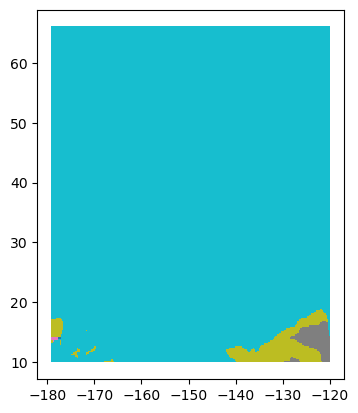

In [19]:
# investigate very large polygons
# 70 polygons greater than 5,000,000 km2 
# these are meeting all 5 criteria but may not be ARs.... can these be filtered before exporting to geodataframe, or is it easier to deal with them afterwards?
display(gdf[gdf['espg3338_area_km2']>5000000])
gdf[gdf['espg3338_area_km2']>5000000].plot(column='time')